In [45]:
import pandas as pd
import matplotlib.pyplot as plt

from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split

%matplotlib inline

sessions = pd.read_json("../data/raw/second/sessions.jsonl", lines=True)
buy_sessions = sessions[sessions['event_type'] == 'BUY_PRODUCT'].copy()
buy_sessions['purchase_id'] = buy_sessions['purchase_id'].astype(int)
buy_sessions['date']=buy_sessions['timestamp'].dt.date
buy_sessions.drop(columns=['user_id', 'event_type', 'offered_discount','session_id','timestamp'], inplace=True)
products_per_day = buy_sessions.groupby(by=['date','product_id']).count().unstack(fill_value=0).stack().rename(columns={'purchase_id': 'amount'}).reset_index()
print(products_per_day)

              date  product_id  amount
0       2019-08-01        1002       1
1       2019-08-01        1003       0
2       2019-08-01        1004       0
3       2019-08-01        1005       0
4       2019-08-01        1006       1
...            ...         ...     ...
171976  2021-12-20        1310       0
171977  2021-12-20        1311       0
171978  2021-12-20        1312       0
171979  2021-12-20        1313       0
171980  2021-12-20        1314       0

[171981 rows x 3 columns]


In [46]:
products_per_day['date']=pd.to_datetime(products_per_day['date'])
products_per_day['product_id'] = products_per_day['product_id'].astype(str)
df=products_per_day[products_per_day['product_id']=='1007']
print(df)
df=df.groupby(pd.Grouper(key='date', freq="W")).sum()

             date product_id  amount
5      2019-08-01       1007       2
202    2019-08-02       1007       3
399    2019-08-03       1007       7
596    2019-08-04       1007       6
793    2019-08-05       1007       1
...           ...        ...     ...
171001 2021-12-16       1007       0
171198 2021-12-17       1007       1
171395 2021-12-18       1007       0
171592 2021-12-19       1007       0
171789 2021-12-20       1007       0

[873 rows x 3 columns]


In [47]:
print(df)

            amount
date              
2019-08-04      18
2019-08-11       1
2019-08-18       1
2019-08-25       0
2019-09-01       0
...            ...
2021-11-28       0
2021-12-05       0
2021-12-12       0
2021-12-19       1
2021-12-26       0

[126 rows x 1 columns]


<AxesSubplot:xlabel='date'>

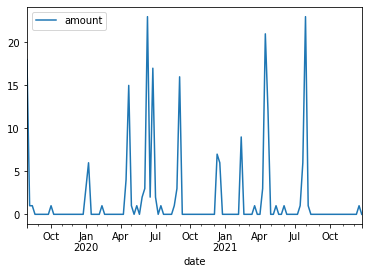

In [48]:
df.plot(y='amount',use_index=True)

In [50]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
from pmdarima import auto_arima
stepwise_fit = auto_arima(df['amount'], trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=746.833, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=747.079, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=743.404, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=744.192, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=761.210, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=745.213, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=745.311, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=751.143, Time=0.01 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.565 seconds


In [51]:
cutoff_point=int(len(df)*0.2)
train=df[:-cutoff_point]
test=df[-cutoff_point:]
print(len(train))
print(len(test))
model=ARIMA(train['amount'],order=(0,0,0),freq='W')
model=model.fit()
model.summary()

101
25


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 amount   No. Observations:                  101
Model:                          ARIMA   Log Likelihood                -297.827
Date:                Wed, 12 Jan 2022   AIC                            599.655
Time:                        00:05:22   BIC                            604.885
Sample:                    08-04-2019   HQIC                           601.772
                         - 07-04-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.8119      1.330      1.362      0.173      -0.796       4.419
sigma2        21.3211      3.725      5.723      0.000      14.020      28.622
===================================================================================
Ljung-Box (L1) (Q):                   3.71   Jarque-Bera (JB):               492.95
Prob(Q):                              0.05   Prob(JB):                         0.00
Heteroskedasticity (H):               1.76   Skew:                             3.10
Prob(H) (two-sided):                  0.11   Kurtosis:                        11.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='date'>

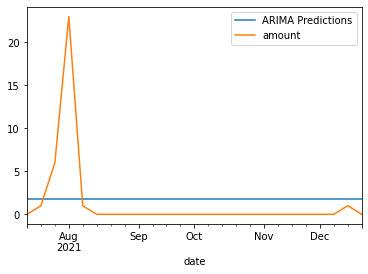

In [54]:
start=len(train)
end=len(train)+len(test)-1
pred=model.predict(start=start,end=end,typ='levels').rename('ARIMA Predictions')
pred.plot(legend=True)
test['amount'].plot(legend=True)